In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yfinance_loader import download_tickers
import timeit

%matplotlib inline

In [2]:
tickers = pd.read_csv('ticker_lists/ndx.csv', header=None)
tickers = tickers[0].to_list()

In [66]:
# Timing 
i = 1
setup_code = 'from yfinance_loader import download_tickers'
run = """download_tickers(['XACTC25.CO'], False, return_only=['Adj Close','Volume'])"""
timeit.timeit(run, setup=setup_code, number=i)/i

[*********************100%***********************]  1 of 1 completed


0.31569908699975713

In [19]:
tickers = ['NOVO-B.CO', 'AMBU-B.CO', 'TSLA']
stocks = download_tickers(tickers, False, return_only=['Adj Close'])
stocks = stocks.ffill(axis=0)

[*********************100%***********************]  2 of 2 completed


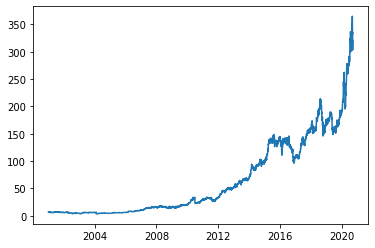

In [20]:
import matplotlib.pyplot as plt
import mpld3

fig, ax = plt.subplots()
ax.plot(stocks.mean(axis=1).iloc[0:-1])

#mpld3.show(fig)
html = mpld3.fig_to_html(fig)
#print(html)

In [8]:
import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada')
fig.write_html("graph.html")